In [65]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,timedelta,datetime
import talib
import time
import os
from IPython.display import clear_output
from plotly.subplots import make_subplots
from ta.volume import VolumeWeightedAveragePrice
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import mplfinance as mpf
import matplotlib.pyplot as plt
import datetime as dt
import pandas_ta as ta
from sklearn import metrics
from scipy import stats
end_date = '2023-08-27'
start_date = '2013-01-01'
start_date_new = datetime.strptime(start_date, "%Y-%m-%d").strftime("%d-%b-%Y")
end_date_new= datetime.strptime(end_date, "%Y-%m-%d").strftime("%d-%b-%Y")
start_date_vix= datetime.strptime(start_date, "%Y-%m-%d").strftime("%d-%m-%Y")
end_date_vix= datetime.strptime(end_date, "%Y-%m-%d").strftime("%d-%m-%Y")

In [66]:
# Functions used in the code

def vwap(dataframe, label='vwap', window=10, fillna=True):
        dataframe[label] = VolumeWeightedAveragePrice(high=dataframe['High'], low=dataframe['Low'], close=dataframe["Adj Close"], volume=dataframe['Volume'], window=window, fillna=fillna).volume_weighted_average_price()
        return dataframe
def na_rows(df):
  '''
  This functions returns rows 
  where NaN values are present
  '''
  return df[df.isna().any(axis=1)]
def check_adfuller(df):
    # Dickey-Fuller test
    print("NULL HYPOTHESIS: time series is NOT stationary")
    print("ALTERNATE HYPOTHESIS: time series is stationary")
    result = adfuller(df, autolag = 'AIC')
    print('Test statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:' ,result[4])
    if (result[0] > result[4]["5%"]):
        print("Test statistic is greater than 5% critical value, ACCEPT NULL HYPOTHESIS")
    else:
        print("Test statistic is less than 5% critical value, REJECT NULL HYPOTHESIS")

    if result[1] < 0.05:
        print("p-value is less than 0.05, REJECT NULL HYPOTHESIS")
    else:
        print("p-value is greater than 0.05, ACCEPT NULL HYPOTHESIS")
        
def fn_keltner_channels(df,kc_lookback_period=7,KC_mult_high= 1): 
        
        df["KC_basis"]        = talib.SMA(df.Close, kc_lookback_period)
        df["devKC"]           = talib.SMA(ta.TRANGE(df.High,df.Low,df.Close),kc_lookback_period)
        df["KC_upper_high"]   = df.KC_basis + df.devKC * KC_mult_high
        df["KC_lower_high"]   = df.KC_basis - df.devKC * KC_mult_high

        return df
def fn_relative_strength(prices, n=14):

        deltas = np.diff(prices)
        seed = deltas[:n + 1]
        up = seed[seed >= 0].sum() / n
        down = -seed[seed < 0].sum() / n
        rs = up / down
        rsi = np.zeros_like(prices)
        rsi[:n] = 100. - 100. / (1. + rs)

        for i in range(n, len(prices)):
            delta = deltas[i - 1]  # cause the diff is 1 shorter

            if delta > 0:
                upval = delta
                downval = 0.
            else:
                upval = 0.
                downval = -delta

            up = (up * (n - 1) + upval) / n
            down = (down * (n - 1) + downval) / n

            rs = up / down
            rsi[i] = 100. - 100. / (1. + rs)

        return rsi
def convert_date(date_str):
    return datetime.strptime(date_str, '%d-%B-%Y').strftime('%Y-%m-%d')
def remove_outliers(df,z_threshold):
    z_scores = np.abs((df - df.mean()) / df.std())
    outlier_indices = np.any(z_scores > z_threshold, axis=1)
    cleaned_data = df[~outlier_indices]
    return cleaned_data

def SMA(ts, window):
    rmse = []
    for i in tqdm(window):
        rolling_mean = ts.rolling(i).mean().shift(1) # shifting by 1 because mean of last i values will be predicted as (i+1)th prediction
        rmse.append(mean_squared_error(ts.values[i:], rolling_mean.dropna(), squared = False))

    plt.figure()
    plt.plot(window, rmse, "bo-", label = "train rmse")
    plt.legend()
    plt.xlabel("window")
    plt.ylabel("RMSE")
    plt.title("train RMSE wrt window size")
    plt.grid()
    plt.show()
def fn_pivot_point(df,Type='Standard'):
        if Type=='Standard':
            df['PP_standard']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_standard']=(2*df['PP_standard'])-df['Low'].iloc[-1]
            df['R2_standard']=(df['PP_standard']+(df['High'].iloc[-1]-df['Low'].iloc[-1]))
            df['R3_standard']=(df['High'].iloc[-1]+(2*(df['PP_standard']-df['Low'].iloc[-1])))
            df['S1_standard']=(2*df['PP_standard'])-df['High'].iloc[-1]
            df['S2_standard']=(df['PP_standard']-(df['High'].iloc[-1]-df['Low'].iloc[-1]))
            df['S3_standard']=(df['Low'].iloc[-1]+(2*(df['High'].iloc[-1]-df['PP_standard'])))
            return df
        
        elif Type=='Fibonacci':
            df['PP_fibonacci']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_fibonacci']=df['PP_fibonacci'] + 0.382 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['R2_fibonacci']=df['PP_fibonacci'] + 0.618 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['R3_fibonacci']=df['PP_fibonacci'] + (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S1_fibonacci']=df['PP_fibonacci'] - 0.382 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S2_fibonacci']=df['PP_fibonacci'] - 0.618 * (df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S3_fibonacci']=df['PP_fibonacci'] - (df['High'].iloc[-1] - df['Low'].iloc[-1])
            return df
        
        elif Type=='Camarilla':
            df['PP_camarilla']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 12
            df['R2_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 6
            df['R3_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 4
            df['R4_camarilla']=df['Close'] + 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 2
            df['S1_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 12
            df['S2_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 6
            df['S3_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 4
            df['S4_camarilla']=df['Close'] - 1.1 * (df['High'].iloc[-1] - df['Low'].iloc[-1]) / 2
            return df
        
        elif Type=='Classic':
            df['PP_classic']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+df['Close'].iloc[-1])/3
            df['R1_classic']=(2 * df['PP_classic']) - df['Low'].iloc[-1]
            df['R2_classic']=df['PP_classic'] +df['High'].iloc[-1] - df['Low'].iloc[-1]
            df['R3_classic']=df['PP_classic'] +2*(df['High'].iloc[-1] - df['Low'].iloc[-1])
            df['S1_classic']=(2 * df['PP_classic']) - df['High'].iloc[-1]
            df['S2_classic']=df['PP_classic']-df['High'].iloc[-1] + df['Low'].iloc[-1]
            df['S3_classic']=df['PP_classic'] -2*(df['High'].iloc[-1] - df['Low'].iloc[-1])
            return df
        
        elif Type=='Woodies':
            df['PP_woodies']=(df['High'].iloc[-1]+df['Low'].iloc[-1]+2*df['Close'].iloc[-1])/4
            df['R1_woodies']=(2 * df['PP_woodies']) - df['Low'].iloc[-1]
            df['R2_woodies']=df['PP_woodies'] +df['High'].iloc[-1] - df['Low'].iloc[-1]
            df['S1_woodies']=(2 * df['PP_woodies']) - df['High'].iloc[-1]
            df['S2_woodies']=df['PP_woodies']-df['High'].iloc[-1] + df['Low'].iloc[-1]
            return df
        
        elif Type=='DeMarks':
            x=np.where(df['Close'].iloc[-1]<df['Open'].iloc[-1],(df['High'].iloc[-1]+(2*df['Low'].iloc[-1]))+(df['Close'].iloc[-1]),(df['Low'].iloc[-1]+(2*df['High'].iloc[-1])+df['Close'].iloc[-1]))
            df['PP_DeMarks']=x/4
            df['R1_DeMarks']=( x/2) - df['Low'].iloc[-1]
            df['S1_DeMarks']= (x/2) - df['High'].iloc[-1]
            return df
        else:
            print('Incorrect pivot type')
def fn_replace_nan_mean(df):
        missing_data = df.isnull()
        for column in missing_data.columns.values.tolist():
            rolling_mean = df[column].rolling(window=10, min_periods=1).median()
            df[column] = df[column].fillna(rolling_mean)
        return df
def fn_ACF__PACF_autocorrelation(df,lags=30):
        
    # Plot ACF and PACF
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot ACF
    plot_acf(df['Adj Close'], lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(df['Adj Close'], lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # Use ddof=1 for sample standard deviation
    threshold = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    
    max_deviation = max(abs(data - mean))
    G = max_deviation / std_dev
    
    is_outlier = G > threshold
    
    return is_outlier

### OHLC Data with technical indicators

In [67]:

Nifty_OHLC=yf.download('^NSEI',start_date,end_date)
Nifty_OHLC['rsi'] =fn_relative_strength(Nifty_OHLC['Adj Close'], n=14)
Nifty_OHLC['rsi_change'] =Nifty_OHLC['rsi']-Nifty_OHLC['rsi'].shift(1)
Nifty_OHLC['Daily_return']=Nifty_OHLC['Adj Close'].pct_change() * 100
Nifty_OHLC['EMA']=Nifty_OHLC['Adj Close'].ewm(span=14, adjust=False).mean()
Nifty_OHLC['Open-prev_Close']=Nifty_OHLC['Open']-Nifty_OHLC['Adj Close'].shift(1)
Nifty_OHLC['Close-Open']=Nifty_OHLC['Adj Close']-Nifty_OHLC['Open']
Nifty_OHLC['Close-High']=Nifty_OHLC['Adj Close']-Nifty_OHLC['High']
Nifty_OHLC['Close-Low']=Nifty_OHLC['Adj Close']-Nifty_OHLC['Low']
Nifty_OHLC['DayOfWeekNumeric'] = Nifty_OHLC.index.dayofweek
Nifty_OHLC['Log_Return'] = np.log(Nifty_OHLC['Adj Close'] / Nifty_OHLC['Adj Close'].shift(1))
Nifty_OHLC['Momentum']=np.where((Nifty_OHLC['Adj Close'].pct_change()*100)>0.25,1,-1)
columns_to_drop = ['Close']
Nifty_OHLC = Nifty_OHLC.drop(columns=columns_to_drop)
Nifty_OHLC

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume,rsi,rsi_change,Daily_return,EMA,Open-prev_Close,Close-Open,Close-High,Close-Low,DayOfWeekNumeric,Log_Return,Momentum
Date,,,,,,,,,,,,,,,,
2013-01-02,5982.600098,6006.049805,5982.000000,5993.250000,0,57.738595,NaN,NaN,5993.250000,NaN,10.649902,-12.799805,11.250000,2,NaN,-1
2013-01-03,6015.799805,6017.000000,5986.549805,6009.500000,0,57.738595,0.000000,0.271138,5995.416667,22.549805,-6.299805,-7.500000,22.950195,3,0.002708,1
2013-01-04,6011.950195,6020.750000,5981.549805,6016.149902,0,57.738595,0.000000,0.110656,5998.181098,2.450195,4.199707,-4.600098,34.600098,4,0.001106,-1
2013-01-07,6042.149902,6042.149902,5977.149902,5988.399902,0,57.738595,0.000000,-0.461258,5996.876939,26.000000,-53.750000,-53.750000,11.250000,0,-0.004623,-1
2013-01-08,5983.450195,6007.049805,5964.399902,6001.700195,0,57.738595,0.000000,0.222101,5997.520040,-4.949707,18.250000,-5.349609,37.300293,1,0.002219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-21,19320.650391,19425.949219,19296.300781,19393.599609,262600,46.974751,4.152780,0.432152,19474.490761,10.500000,72.949219,-32.349609,97.298828,0,0.004312,1
2023-08-22,19417.099609,19443.500000,19381.300781,19396.449219,208700,47.115998,0.141248,0.014694,19464.085222,23.500000,-20.650391,-47.050781,15.148438,1,0.000147,-1
2023-08-23,19439.199219,19472.050781,19366.599609,19444.000000,225200,49.531867,2.415869,0.245152,19461.407192,42.750000,4.800781,-28.050781,77.400391,2,0.002449,-1


### FII DII Data

In [42]:
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        pass
FII_DII_Data = pd.read_csv('Fii_Dii.csv', encoding=encoding)
FII_DII_Data['Date'] = pd.to_datetime(FII_DII_Data['Date'])

FII_DII_Data.set_index('Date', inplace=True)
columns_to_drop = ['FII_Gross_Purchase','FII_Gross_Sales','DII_Gross_Purchase','DII_Gross_Sales']
FII_DII_Data = FII_DII_Data.drop(columns=columns_to_drop)
FII_DII_Data

,FII_Net,DII_Net,Net_ FII_DII
Date,,,
2013-01-02,1107.66,-417.41,690.25
2013-01-03,1397.37,-905.96,491.41
2013-01-04,1164.41,-825.40,339.01
2013-01-07,887.38,-1028.12,-140.74
2013-01-08,887.38,-1028.12,-140.74
...,...,...,...
2023-08-21,-1901.10,626.25,-1274.85
2023-08-22,-495.17,533.75,38.58
2023-08-23,614.32,125.03,739.35


### Maxpain data

In [43]:
maxpain_Data = pd.read_csv('Maxpain_PCR_data.csv')
maxpain_Data['Date'] = pd.to_datetime(maxpain_Data['Date'])

maxpain_Data.set_index('Date', inplace=True)
columns_to_drop = ['expiry']
maxpain_Data = maxpain_Data.drop(columns=columns_to_drop)
maxpain_Data

,maxPain,wmaxPain,pcr,atm_pcr
Date,,,,
2022-05-02,16950,16970,0.697184,2.840167
2022-05-04,17050,17063,0.710092,0.895641
2022-05-05,16850,16792,0.576895,0.784431
2022-05-06,16450,16456,0.480607,8.095098
2022-05-09,16150,16170,0.456921,7.751028
...,...,...,...,...
2023-03-23,17050,17049,0.921391,1.435953
2023-03-24,17050,17016,0.730054,1.123703
2023-03-27,17000,16997,0.456252,1.128934


#### PE,PB,DIV ratio data

In [44]:
from nsepython import *
import pandas as pd
from datetime import date,timedelta,datetime
symbol = "NIFTY 50"
pe_pb_data=pd.DataFrame(index_pe_pb_div(symbol,start_date_new,end_date_new))
pe_pb_data['Date'] = pd.to_datetime(pe_pb_data['DATE'])
pe_pb_data.set_index('Date', inplace=True)
pe_pb_data['pe'] = pd.to_numeric(pe_pb_data['pe'], errors='coerce')
columns_to_drop = ['Index Name','pb','divYield','DATE']
pe_pb_data = pe_pb_data.drop(columns=columns_to_drop)

### Crude oil prices

In [45]:
crude_prices=yf.download('CL=F',start_date,end_date)
vwap(crude_prices, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'crude_Open', 'High': 'crude_High','Low': 'crude_Low', 'Close': 'crude_Close','Adj Close': 'crude_Adj Close','Volume': 'crude_Volume','vwap':'crude_VWAP'}
crude_prices.rename(columns=new_column_names, inplace=True)
columns_to_drop = ['crude_Close']
crude_prices = crude_prices.drop(columns=columns_to_drop)
crude_prices

[*********************100%***********************]  1 of 1 completed


,crude_Open,crude_High,crude_Low,crude_Adj Close,crude_Volume,crude_VWAP
Date,,,,,,
2013-01-02,91.779999,93.870003,91.559998,93.120003,203865,92.850001
2013-01-03,92.910004,93.300003,92.489998,92.919998,189812,92.875715
2013-01-04,92.860001,93.209999,91.519997,93.089996,210747,92.781904
2013-01-07,93.209999,93.349998,92.419998,93.190002,166292,92.817483
2013-01-08,93.320000,93.800003,92.669998,93.150002,195867,92.922095
...,...,...,...,...,...,...
2023-08-21,81.430000,82.470001,80.610001,80.720001,115874,80.592982
2023-08-22,80.800003,80.989998,80.099998,80.349998,287489,80.732661
2023-08-23,79.639999,79.910004,77.620003,78.889999,378146,79.786969


### USD-INR Prices

In [46]:
USD_INR=yf.download('USDINR=X',start_date,end_date)
new_column_names = {'Open': 'USD_INR_Open', 'High': 'USD_INR_High','Low': 'USD_INR_Low', 'Close': 'USD_INR_Close','Adj Close': 'USD_INR_Adj Close','Volume': 'USD_INR_Volume'}
USD_INR.rename(columns=new_column_names, inplace=True)
columns_to_drop = ['USD_INR_Close']
USD_INR = USD_INR.drop(columns=columns_to_drop)

[*********************100%***********************]  1 of 1 completed


### Gold prices

In [47]:
Gold_price=yf.download('GC=F',start_date,end_date)
vwap(Gold_price, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'Gold_price_Open', 'High': 'Gold_price_High','Low': 'Gold_price_Low', 'Close': 'Gold_price_Close','Adj Close': 'Gold_price_Adj Close','Volume': 'Gold_price_Volume','vwap':'Gold_price_VWAP'}
Gold_price.rename(columns=new_column_names, inplace=True)
columns_to_drop = ['Gold_price_Close']
Gold_price = Gold_price.drop(columns=columns_to_drop)
Gold_price

[*********************100%***********************]  1 of 1 completed


,Gold_price_Open,Gold_price_High,Gold_price_Low,Gold_price_Adj Close,Gold_price_Volume,Gold_price_VWAP
Date,,,,,,
2013-01-02,1672.800049,1693.800049,1670.000000,1687.900024,35,1683.900024
2013-01-03,1686.099976,1686.800049,1662.000000,1673.699951,140,1676.113338
2013-01-04,1647.000000,1658.300049,1625.699951,1648.099976,199,1659.044026
2013-01-07,1656.500000,1659.900024,1643.800049,1645.500000,49,1655.626030
2013-01-08,1647.699951,1661.500000,1647.699951,1661.500000,17,1645.912702
...,...,...,...,...,...,...
2023-08-21,1893.599976,1893.599976,1893.300049,1893.300049,876,1892.615136
2023-08-22,1894.599976,1896.800049,1892.800049,1896.400024,46,1893.385501
2023-08-23,1909.599976,1918.500000,1909.599976,1918.500000,547,1901.702168


### S&P 500

In [48]:
SP500=yf.download('^GSPC',start_date,end_date)
vwap(SP500, label='vwap', window=3, fillna=True)
new_column_names = {'Open': 'SP500_Open', 'High': 'SP500_High','Low': 'SP500_Low', 'Close': 'SP500_Close','Adj Close': 'SP500_Adj Close','Volume': 'SP500_Volume','vwap':'SP500_VWAP'}
SP500.rename(columns=new_column_names, inplace=True)
columns_to_drop = ['SP500_Close']
SP500 = SP500.drop(columns=columns_to_drop)


[*********************100%***********************]  1 of 1 completed


### India VIX

In [49]:
from nselib import capital_market
vix_data = capital_market.india_vix_data(start_date_vix,end_date_vix)
new_column_names = {'TIMESTAMP': 'Date','CLOSE_INDEX_VAL':'INDIAVIX_Close','PREV_CLOSE':'INDIAVIX_PREV_CLOSE'}
vix_data.rename(columns=new_column_names, inplace=True)
vix_data['Date'] = pd.to_datetime(vix_data['Date'])
vix_data.set_index('Date',inplace=True)
columns_to_drop = ['INDEX_NAME','INDIAVIX_PREV_CLOSE','VIX_PTS_CHG']
vix_data = vix_data.drop(columns=columns_to_drop)
vix_data['vix_Dailyreturn_EMA']=vix_data['VIX_PERC_CHG'].ewm(span=14, adjust=False).mean()
vix_data

,OPEN_INDEX_VAL,INDIAVIX_Close,HIGH_INDEX_VAL,LOW_INDEX_VAL,VIX_PERC_CHG,vix_Dailyreturn_EMA
Date,,,,,,
2013-01-01,14.9500,13.6900,14.9500,13.6400,-8.428094,-8.428094
2013-01-02,13.6900,13.7100,13.9100,12.9900,0.146092,-7.284869
2013-01-03,13.7100,13.4700,13.9400,13.2200,-1.750547,-6.546959
2013-01-04,13.4700,13.3700,13.6300,13.2800,-0.742390,-5.773017
2013-01-07,13.3700,13.9200,14.0400,13.3700,4.113687,-4.454790
...,...,...,...,...,...,...
2023-08-18,12.2400,12.1425,12.4925,10.7875,-0.796569,0.842257
2023-08-21,12.1425,11.9600,12.5900,11.1725,-1.502985,0.529558
2023-08-22,11.9600,11.7475,12.0850,11.5900,-1.776756,0.222050


### Top 10 stocks

In [50]:
ticker_list=['HDFCBANK.NS','RELIANCE.NS','ICICIBANK.NS','INFY.NS','ITC.NS','TCS.NS','LT.NS','KOTAKBANK.NS','AXISBANK.NS','SBIN.NS']
df_Top_stocks=pd.DataFrame()
for ticker in ticker_list:
    df=yf.download(ticker,start_date,end_date)
    df_Top_stocks[f'{ticker}_Adj_Close']=df['Adj Close']
    clear_output(wait=False)
df_Top_stocks

,HDFCBANK.NS_Adj_Close,RELIANCE.NS_Adj_Close,ICICIBANK.NS_Adj_Close,INFY.NS_Adj_Close,ITC.NS_Adj_Close,TCS.NS_Adj_Close,LT.NS_Adj_Close,KOTAKBANK.NS_Adj_Close,AXISBANK.NS_Adj_Close,SBIN.NS_Adj_Close
Date,,,,,,,,,,
2013-01-01,315.591248,386.519775,183.236801,220.877106,144.731918,506.066254,606.568237,322.760620,257.542267,216.812424
2013-01-02,316.905273,389.853027,185.696396,220.910660,143.799774,505.726288,615.770020,326.212006,262.106445,218.965790
2013-01-03,315.061066,395.737885,185.388000,223.656235,142.867661,512.651611,611.029114,325.218811,262.692291,220.846725
2013-01-04,313.216888,396.243683,187.025085,224.770706,142.288254,520.097778,607.725403,322.884766,260.613373,222.195953
2013-01-07,308.076141,393.829956,186.985550,227.186325,140.600342,518.356262,592.849609,322.015717,259.460510,220.489304
...,...,...,...,...,...,...,...,...,...,...
2023-08-21,1589.500000,2520.000000,955.200012,1405.400024,447.799988,3401.649902,2662.250000,1760.349976,952.599976,571.700012
2023-08-22,1582.699951,2519.399902,952.000000,1403.750000,454.250000,3382.149902,2678.800049,1763.099976,957.049988,568.500000
2023-08-23,1586.599976,2522.199951,966.849976,1407.949951,450.450012,3398.250000,2717.600098,1780.050049,979.250000,576.900024


In [68]:
# all data combined in one dataframe
concatenated_df = pd.concat([Nifty_OHLC, FII_DII_Data,pe_pb_data,crude_prices,USD_INR,Gold_price,SP500,vix_data,df_Top_stocks,maxpain_Data], axis=1)
concatenated_df.dropna(inplace=True,axis=0)
column_names_list = concatenated_df.columns.tolist()

for column in column_names_list:
    concatenated_df[f'sma_{column}'] = talib.SMA(concatenated_df[column], timeperiod=5)
    
columns_to_shift = concatenated_df.columns.tolist()

# Number of previous days to shift
num_days = 1
new_columns_list=[]

# Create previous day columns using a loop
for column in columns_to_shift:
    for i in range(1, num_days + 1):
        concatenated_df[f'{column}_prev_{i}'] = concatenated_df[column].shift(i)
        new_columns_list.append(f'{column}_prev_{i}')

concatenated_df.dropna(inplace=True,axis=0)

concatenated_df['indicator_1_Open_prev_close']=np.where((concatenated_df['Open-prev_Close']>0),1,-1)
concatenated_df['indicator_2_rsi50']=np.where((concatenated_df['rsi_prev_1']>50),1,-1)
concatenated_df['indicator_3_sp500']=np.where((concatenated_df['SP500_Adj Close_prev_1']>concatenated_df['sma_SP500_Adj Close_prev_1']),1,-1)
concatenated_df['indicator_4_pe']=np.where((concatenated_df['pe_prev_1']>concatenated_df['sma_pe_prev_1']) |(concatenated_df['pe_prev_1']>25),1,-1)
concatenated_df['indicator_5_FIIDII']=np.where((concatenated_df['Net_ FII_DII_prev_1']>concatenated_df['sma_Net_ FII_DII_prev_1']),1,-1)
concatenated_df['indicator_6_INDIAVIX']=np.where((concatenated_df['INDIAVIX_Close_prev_1']>concatenated_df['sma_INDIAVIX_Close_prev_1']),-1,1)
concatenated_df['indicator_7_REL']=np.where((concatenated_df['RELIANCE.NS_Adj_Close_prev_1']>concatenated_df['sma_RELIANCE.NS_Adj_Close_prev_1']),1,-1)
concatenated_df['indicator_8_HDFC']=np.where((concatenated_df['HDFCBANK.NS_Adj_Close_prev_1']>concatenated_df['sma_HDFCBANK.NS_Adj_Close_prev_1']),1,-1)

corr = concatenated_df[concatenated_df.columns.tolist()].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.to_csv('corr.csv')
concatenated_df.to_csv('y.csv')

In [69]:
columns_list=concatenated_df.columns.tolist()
columns_list

['Open',
 'High',
 'Low',
 'Adj Close',
 'Volume',
 'rsi',
 'rsi_change',
 'Daily_return',
 'EMA',
 'Open-prev_Close',
 'Close-Open',
 'Close-High',
 'Close-Low',
 'DayOfWeekNumeric',
 'Log_Return',
 'Momentum',
 'FII_Net',
 'DII_Net',
 'Net_ FII_DII',
 'pe',
 'crude_Open',
 'crude_High',
 'crude_Low',
 'crude_Adj Close',
 'crude_Volume',
 'crude_VWAP',
 'USD_INR_Open',
 'USD_INR_High',
 'USD_INR_Low',
 'USD_INR_Adj Close',
 'USD_INR_Volume',
 'Gold_price_Open',
 'Gold_price_High',
 'Gold_price_Low',
 'Gold_price_Adj Close',
 'Gold_price_Volume',
 'Gold_price_VWAP',
 'SP500_Open',
 'SP500_High',
 'SP500_Low',
 'SP500_Adj Close',
 'SP500_Volume',
 'SP500_VWAP',
 'OPEN_INDEX_VAL',
 'INDIAVIX_Close',
 'HIGH_INDEX_VAL',
 'LOW_INDEX_VAL',
 'VIX_PERC_CHG',
 'vix_Dailyreturn_EMA',
 'HDFCBANK.NS_Adj_Close',
 'RELIANCE.NS_Adj_Close',
 'ICICIBANK.NS_Adj_Close',
 'INFY.NS_Adj_Close',
 'ITC.NS_Adj_Close',
 'TCS.NS_Adj_Close',
 'LT.NS_Adj_Close',
 'KOTAKBANK.NS_Adj_Close',
 'AXISBANK.NS_Adj_Close',

### Logistic regression to check classification

Training Accuracy: 0.72
Testing Accuracy: 0.66
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.79      0.72      0.76        47
         1.0       0.38      0.47      0.42        17

    accuracy                           0.66        64
   macro avg       0.59      0.60      0.59        64
weighted avg       0.68      0.66      0.67        64



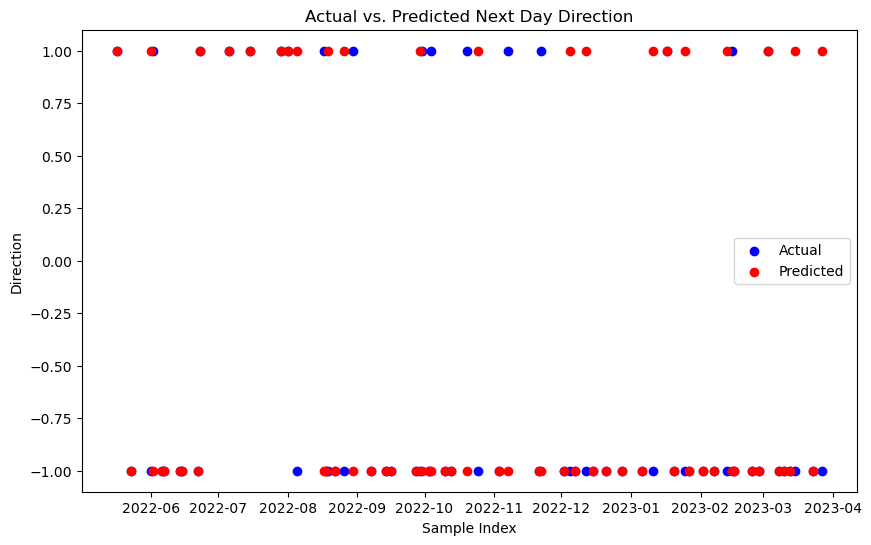

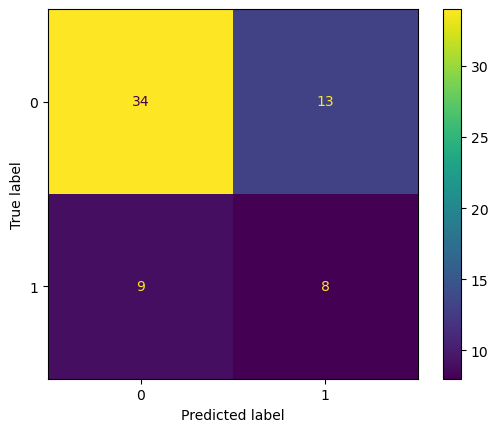

Accuracy: 0.65625


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

data = concatenated_df

#features = ['Daily_return_prev_1','FII_DII_Net_ema_prev_1','vwap_prev_1','pivotpoint_direction_up_prev_1','pivotpoint_direction_down_prev_1','SP500_VWAP_prev_1','rsi_prev_1','vwap_prev_1','EMA_prev_1','SP500_Adj Close_%Change_prev_1','Net_ FII_DII_prev_1','sma_slope_90_90_prev_1','INDIAVIX_PREV_CLOSE']
features = [
    'Open',
 'rsi_change_prev_1',
 'Open-prev_Close_prev_1',
 'Close-Open_prev_1',
 #'atm_pcr_prev_1',
 'indicator_1_Open_prev_close',
 'indicator_2_rsi50',
 'indicator_3_sp500',
 'indicator_4_pe',
 'indicator_5_FIIDII',
 'indicator_6_INDIAVIX',
 'indicator_7_REL',
 'indicator_8_HDFC'     
 ]  

target = 'Momentum'  # 'up=1', 'down=-1', 'flat'

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Prepare the feature matrices and target vectors
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

#Standardisation of model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, predictions))

# You can also use the trained model to make predictions for new data
# new_data = pd.DataFrame(...)  # Prepare new data for prediction
# new_predictions = model.predict(new_data[features])
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual')
plt.scatter(y_test.index, predictions, color='red', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Direction')
plt.title('Actual vs. Predicted Next Day Direction')
plt.legend()
plt.show()
m = metrics.confusion_matrix(y_test,predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m)
disp.plot()
plt.show()
accuracy = np.mean(predictions == y_test)
print('Accuracy:', accuracy)
result_df=pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
result_df.to_csv('result.csv')

In [71]:
model.classes_

array([-1.,  1.])

In [72]:
coefficients = model.coef_
intercept = model.intercept_

In [ ]:

Nifty_momentum_prediction = model.predict(scaler.transform(test_data[  'Open',
 'rsi_change_prev_1',
 'Open-prev_Close_prev_1',
 'Close-Open_prev_1',
 'pcr_prev_1',
 'atm_pcr_prev_1',
 'indicator_1_Open_prev_close',
 'indicator_2_rsi50',
 'indicator_3_sp500',
 'indicator_4_pe',
 'indicator_5_FIIDII',
 'indicator_6_INDIAVIX',
 'indicator_7_REL',
 'indicator_8_HDFC']))

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives for a class. In other words, it measures how many of the predicted positive cases were actually true positives. Higher precision indicates fewer false positives.

Recall (Sensitivity or True Positive Rate): Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. It measures how well the model is capturing the positive cases. Higher recall indicates fewer false negatives.

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure between precision and recall. It is useful when you have imbalanced classes.

Support: The number of occurrences of each class in the true responses.

Accuracy: The overall accuracy of the model, calculated as the ratio of correctly predicted observations to the total observations.

Macro Avg: The average of precision, recall, and F1-score across all classes, without considering class imbalance.

Weighted Avg: The weighted average of precision, recall, and F1-score, where the weights are based on the number of occurrences of each class.